# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df, df_model
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import least_squares
from typing import Union, Optional
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import seaborn as sns

null performances after coercion: 0
after filter num benchmarks 1965
after merge with model versions 1965
after date filter (>= 2022-11-01) 1766
after merge with benchmark dates 1766
Original number of rows: 1766
Number of rows after aggregation: 1324


# Appendix E.3 Varying benchmark inclusion

In [3]:
# MODIFIED: Added anchor_slope and anchor_difficulty to the function signature.
def split_params(params: np.ndarray, num_models: int, num_benchmarks: int, anchor_idx: int, model_type: str, anchor_slope: float, anchor_difficulty: float):
    """
    Breaks the flat parameter vector into C, D, full-length α,
    and gammas (for sigmoid_with_offsets).
    """
    C = params[:num_models]

    # MODIFICATION: Reconstruct D by inserting the fixed anchor difficulty.
    # The optimizer only solves for the other N-1 difficulties.
    D_free = params[num_models : num_models + num_benchmarks - 1]
    D = np.insert(D_free, anchor_idx, anchor_difficulty)

    # MODIFICATION: Adjust index for alpha and insert the fixed anchor slope.
    alpha_free = params[num_models + num_benchmarks - 1 : num_models + 2 * num_benchmarks - 2]
    alpha = np.insert(alpha_free, anchor_idx, anchor_slope)

    # Handle parameters specific to the 'sigmoid_with_offsets' model
    if model_type == 'sigmoid_with_offsets':
        # MODIFICATION: Adjust indices for gamma parameters.
        gamma_lower = params[num_models + 2 * num_benchmarks - 2 : num_models + 3 * num_benchmarks - 2]
        gamma_upper = params[num_models + 3 * num_benchmarks - 2:]
        return C, D, alpha, gamma_lower, gamma_upper

    return C, D, alpha

# MODIFIED: Added anchor_slope and anchor_difficulty to the function signature.
def predict(params, model_idx, bench_idx, num_models, num_benchmarks, anchor_idx, model_type, anchor_slope, anchor_difficulty):
    """Calculates predictions based on the specified model type."""
    # Unpack the parameters based on the model type
    # MODIFICATION: Pass anchor values to split_params
    split_args = (params, num_models, num_benchmarks, anchor_idx, model_type, anchor_slope, anchor_difficulty)
    if model_type == 'sigmoid_with_offsets':
        C, D, alpha, lower_asymptote, upper_asymptote = split_params(*split_args)
    else:
        C, D, alpha = split_params(*split_args)

    # Core prediction logic
    x = alpha[bench_idx] * (C[model_idx] - D[bench_idx])

    # Apply the correct functional form
    if model_type == 'clipped_linear':
        return np.clip(x, 0, 1)
    elif model_type == 'sigmoid_with_offsets':
        return lower_asymptote[bench_idx] + (upper_asymptote[bench_idx] - lower_asymptote[bench_idx]) / (1 + np.exp(-x))
    else:  # Default to 'sigmoid'
        return 1.0 / (1.0 + np.exp(-x))

def calculate_metrics(y_true, y_pred, num_params):
    """
    Calculates R-squared, MSE, AIC, and BIC.
    """
    n_obs = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    mse = rss / n_obs
    tss = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (rss / tss) if tss > 0 else 0
    aic = n_obs * np.log(mse) + 2 * num_params if mse > 0 else -np.inf
    bic = n_obs * np.log(mse) + num_params * np.log(n_obs) if mse > 0 else -np.inf
    return {'r2': r2, 'mse': mse, 'aic': aic, 'bic': bic}

--- Starting Repetition 1/100 ---
Dropping 11 benchmarks: ['OTIS Mock AIME 2024-2025', 'Terminal Bench', 'HellaSwag', 'BBH', 'ARC AI2', 'SWE-Bench verified', 'DeepResearch Bench', 'ARC-AGI', 'Aider polyglot', 'LAMBADA', 'VideoMME']
`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 3.6491e+01, final cost 1.7875e+00, first-order optimality 9.27e-05.
Frontier slope for this repetition: 0.4398 capability units / year
----------------------------------------
--- Starting Repetition 2/100 ---
Dropping 11 benchmarks: ['MATH level 5', 'ANLI', 'VPCT', 'Terminal Bench', 'Cybench', 'SimpleBench', 'OTIS Mock AIME 2024-2025', 'Factorio learning environment', 'MMLU', 'GPQA diamond', 'HellaSwag']
`ftol` termination condition is satisfied.
Function evaluations 22, initial cost 2.8249e+01, final cost 1.6909e+00, first-order optimality 1.51e-04.
Frontier slope for this repetition: 0.4914 capability units / year
----------------------------------------
--- Starting Repetiti

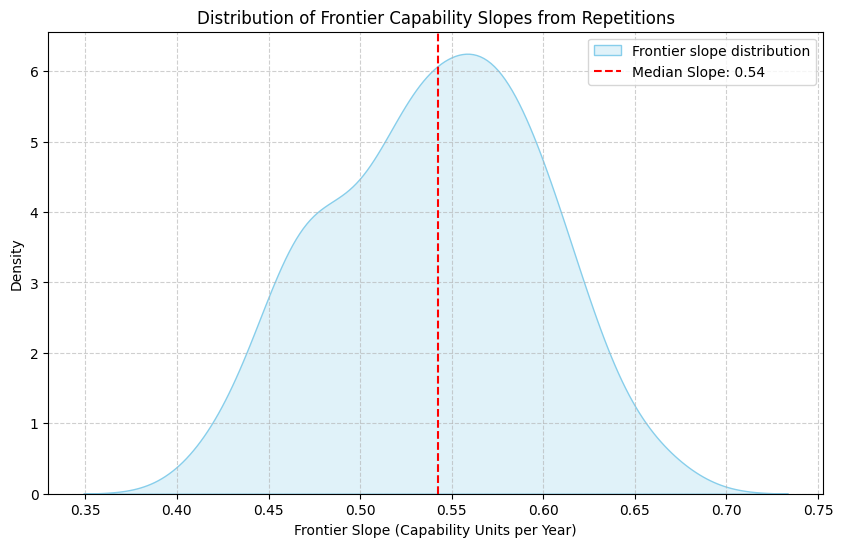

In [9]:
import random
random.seed(42)

TOP_N_AT_RELEASE = 1

def run_analysis():
    # 1. Initial Setup
    n_repetitions = 100 #100
    fraction_to_drop = 0.3
    anchor_benchmark = "Winogrande"
    cutoff_date = pd.Timestamp("2010-01-01") #pd.Timestamp("2023-01-01")
    slopes_per_repetition = []

    # 2. Main Loop
    for i in range(n_repetitions):
        print(f"--- Starting Repetition {i + 1}/{n_repetitions} ---")

        if scores_df.empty or df_model.empty:
            print("Dataframes `scores_df` or `df_model` not loaded. Halting script.")
            return

        # a. Randomly drop benchmarks
        all_unique_benchmarks = list(scores_df['benchmark'].unique())
        eligible_to_drop = [b for b in all_unique_benchmarks if b != anchor_benchmark]
        num_benchmarks_to_drop = int(len(all_unique_benchmarks) * fraction_to_drop)
        k = min(num_benchmarks_to_drop, len(eligible_to_drop))
        benchmarks_to_drop = random.sample(eligible_to_drop, k=k) if k > 0 else []
        print(f"Dropping {len(benchmarks_to_drop)} benchmarks: {benchmarks_to_drop}")
        scores_df_dropped = scores_df[~scores_df['benchmark'].isin(benchmarks_to_drop)].copy()

        # b. Fit statistical model
        # _, df_cm_dropped, _ = fit_statistical_model(scores_df_dropped, anchor_benchmark, 0, 1, df_model=df_model)
        _, df_cm_dropped, _ = fit_statistical_model(scores_df_dropped, 
                         anchor_mode="benchmark",  # "benchmark" or "model"
                         # Benchmark anchoring parameters
                         anchor_benchmark=anchor_benchmark, 
                         anchor_difficulty=0, 
                         anchor_slope=1.0,
                         slope_init=1.0,
                         regularization_strength=0.1,  # NEW: Add L2 regularization
                         df_model=df_model)

        # c. Prepare data for frontier linear fit
        df_cm_dropped.dropna(subset=['date'], inplace=True)
        if df_cm_dropped.empty:
            print("No models with valid dates remaining. Skipping repetition.")
            print("-" * 40)
            continue

        df_cm_dropped['date_obj'] = pd.to_datetime(df_cm_dropped['date'])
        fit_df = (
            df_cm_dropped[df_cm_dropped['date_obj'] >= cutoff_date]
            .dropna(subset=['estimated_capability'])
            .sort_values('date_obj')
            .reset_index(drop=True)
        )

        if fit_df.empty:
            print("No models remain after cutoff to evaluate frontier. Skipping repetition.")
            print("-" * 40)
            continue

        # d. Identify frontier-at-release models (top-N at their release date)
        frontier_rows = []
        for _, row in fit_df.iterrows():
            available = fit_df[fit_df['date_obj'] <= row['date_obj']]
            top_at_release = available.nlargest(TOP_N_AT_RELEASE, 'estimated_capability')
            if row['model'] in top_at_release['model'].values:
                frontier_rows.append(row)

        df_frontier = pd.DataFrame(frontier_rows)
        if df_frontier.empty or len(df_frontier) < 2:
            print("Not enough frontier models to fit a line. Skipping repetition.")
            print("-" * 40)
            continue

        df_frontier = df_frontier.sort_values('date_obj').reset_index(drop=True)
        X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
        y = df_frontier['estimated_capability'].astype(float).values
        lin_reg = LinearRegression().fit(X, y)
        slope_per_year = lin_reg.coef_[0] * 365.25
        slopes_per_repetition.append(slope_per_year)
        print(f"Frontier slope for this repetition: {slope_per_year:.4f} capability units / year")
        print("-" * 40)

    # 3. Final Summary and Plot
    print("\n--- Overall Summary ---")
    if slopes_per_repetition:
        median_slope = np.median(slopes_per_repetition)
        std_slope = np.std(slopes_per_repetition)

        print(f"Frontier slopes from {len(slopes_per_repetition)} successful repetitions:")
        print([round(s, 4) for s in slopes_per_repetition])
        print(f"\nMedian slope: {median_slope:.4f}")
        print(f"Standard deviation of slopes: {std_slope:.4f}")

        # Create the KDE plot
        plt.figure(figsize=(10, 6))
        sns.kdeplot(slopes_per_repetition, fill=True, color='skyblue', label='Frontier slope distribution')
        plt.axvline(median_slope, color='red', linestyle='--', label=f'Median Slope: {median_slope:.2f}')

        plt.title('Distribution of Frontier Capability Slopes from Repetitions')
        plt.xlabel('Frontier Slope (Capability Units per Year)')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

        return slopes_per_repetition

    else:
        print("No frontier slopes were calculated. Check data and cutoff date.")

# Run the entire analysis
x = run_analysis()

In [12]:
np.percentile(x, [2.5, 50, 97.5])

array([0.43425226, 0.54253897, 0.63983225])